# Tarea 1 - Redes densas
## Eduardo García Alarcón

### 3. Red densa conl PyTorch

A partir de la libreta https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2025-1/notebooks/1c_redes_densas_pytorch.ipynb, evalúa tres distintas configuraciones de redes densas que incluyan lo siguiente:

  - Más capas ocultas
  - Distintas funciones de activasión de las capas ocultas
  - Técnicas de regularización
  - Capas de normalizaciónl   

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch as th
from torch import nn

# fijamos las semillas de los PRNG por reproducibilidad
np.random.seed(42)
th.manual_seed(42)

T_LOTE = 8

In [2]:
from sklearn.datasets import load_diabetes

db = load_diabetes(return_X_y=False, as_frame=True)
     

In [3]:
print(db.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [4]:
db['data']

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


/home/qweryedu/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


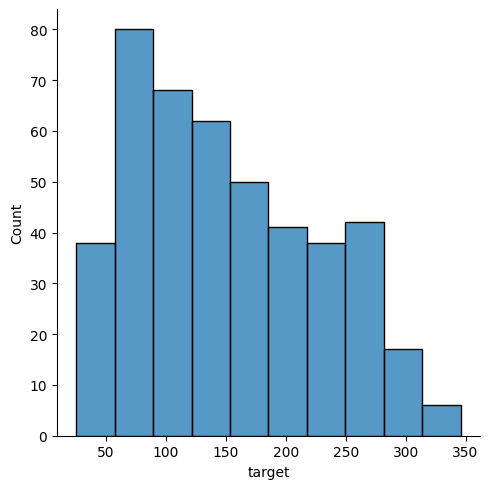

In [5]:
import pandas as pd
import seaborn as sns

sns.displot(db['target'][:])
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

X_ent, X_prueba, y_ent, y_prueba = train_test_split(db['data'].to_numpy(),
                                                    db['target'].to_numpy(),
                                                    test_size = 0.3,
                                                    shuffle=True,
                                                    random_state=42)
X_ent, X_val, y_ent, y_val = train_test_split(X_ent,
                                              y_ent,
                                              test_size = 0.2,
                                              shuffle=True,
                                              random_state=42)

In [7]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_ent)

X_ent = sc.transform(X_ent)
X_val = sc.transform(X_val)
X_prueba = sc.transform(X_prueba)